# Active-Reinforcement Learning

In [1]:
import torch
import numpy as np
import torchvision
from matplotlib import pyplot as plt
import torch.nn as nn
from copy import deepcopy
import time
import torch.nn.functional as F
import sys

device = "cuda:1"
# c = np.random.randn(3,2)
# c=np.clip(a_min=-2.0,a_max=2.0,a=c)
def labels(x,c):
    
    d=c-x
    d=np.clip(a_min=-0.5,a_max=0.5,a=d)-d
    
    for i in d:
        if i[0]==0 and i[1]==0:
             return(1)
    else: return(0.2)
    
def labels_diff_shape(x,c):
    
    d=c-x
    d1=np.clip(a_min=-0.5,a_max=0.5,a=d)-d
    d1_prox = []
    d2=np.clip(a_min=-0.5,a_max=0.9,a=d)-d
    d2_prox = []

    for i in d1:
        if i[0]==0 and i[1]==0:
             d1_prox.append(1)
        else: d1_prox.append(0)
    for i in d2:
        if i[0]==0 and i[1]==0:
             d2_prox.append(1)
        else: d2_prox.append(0)

    if (d1_prox[0]==1 and d2_prox[0]==1) or (d1_prox[1]==1) or (d2_prox[0]==1):
        return(1)
    else: return(0.2)  
    

## Create True Maps

In [2]:
import numpy as np

X_MIN, X_MAX, Y_MIN, Y_MAX = -2.5, 2.5, -2.5, 2.5
TABLE_X_LENGTH, TABLE_Y_LENGTH = 1, 1
SOFA_X_LENGTH, SOFA_Y_LENGTH = 1, 1
map_scale = 32

def random_table_sofa_centers(n_tables, n_sofas):
    """
    Generate random table center locations within the bounds of the room and not
    overlapping with each other.

    :param n_tables: The number of table centers to generate
    :return: The table centers in a list of [x, y] pairs
    """
    def is_overlap(table_centers, sofa_centers, new_x, new_y, new_x_len, new_y_len):
        overlap = False
        for x, y in table_centers:
            if (abs(x - new_x) < (TABLE_X_LENGTH + new_x_len) / 2 and 
                abs(y - new_y) < (TABLE_Y_LENGTH + new_y_len) / 2):
                overlap = True
        for x, y in sofa_centers:
            if (abs(x - new_x) < (SOFA_X_LENGTH + new_x_len) / 2 and 
                abs(y - new_y) < (SOFA_Y_LENGTH + new_y_len) / 2):
                overlap = True
        return overlap

    table_centers, sofa_centers = [], []
    for _ in range(n_tables):
        new_x = X_MIN + TABLE_X_LENGTH / 2 + np.random.rand() * (X_MAX - X_MIN - TABLE_X_LENGTH)
        new_y = Y_MIN + TABLE_Y_LENGTH / 2 + np.random.rand() * (Y_MAX - Y_MIN - TABLE_Y_LENGTH)
        while is_overlap(table_centers, sofa_centers, new_x, new_y, TABLE_X_LENGTH, TABLE_Y_LENGTH):
            new_x = X_MIN + TABLE_X_LENGTH / 2 + np.random.rand() * (X_MAX - X_MIN - TABLE_X_LENGTH)
            new_y = Y_MIN + TABLE_Y_LENGTH / 2 + np.random.rand() * (Y_MAX - Y_MIN - TABLE_Y_LENGTH)
        table_centers.append([new_x, new_y])
    for _ in range(n_sofas):
        new_x = X_MIN + SOFA_X_LENGTH / 2 + np.random.rand() * (X_MAX - X_MIN - SOFA_X_LENGTH)
        new_y = Y_MIN + SOFA_Y_LENGTH / 2 + np.random.rand() * (Y_MAX - Y_MIN - SOFA_Y_LENGTH)
        while is_overlap(table_centers, sofa_centers, new_x, new_y, SOFA_X_LENGTH, SOFA_Y_LENGTH):
            new_x = X_MIN + SOFA_X_LENGTH / 2 + np.random.rand() * (X_MAX - X_MIN - SOFA_X_LENGTH)
            new_y = Y_MIN + SOFA_Y_LENGTH / 2 + np.random.rand() * (Y_MAX - Y_MIN - SOFA_Y_LENGTH)
        sofa_centers.append([new_x, new_y])
    return table_centers, sofa_centers
room_center=[]
for i in range(400):
    temp = random_table_sofa_centers(5,0)
    room_center.append(temp[0])
c_rooms = np.stack(room_center)

## Create Images for input
### Using ground truth

# Centers

In [3]:
xc=np.random.randint(low=-150,high=150,size=(400,30,2))

In [4]:
# #input images from labeller
# imgs_in=[]
# for i,room in enumerate(xc):
#     temp = []
#     for j in room:
#         temp_img=[]
#         temp_x = np.arange(j[0]-100,j[0]+100,5)
#         temp_y = np.arange(j[1]-100,j[1]+100,5)
#         x,y=np.meshgrid(temp_x,temp_y)
#         for k in np.append(x.reshape(1,1600).T,y.reshape(1,1600).T,1):
#             temp_img.append(labels(k/100,c_rooms[i]))
#         temp_img=np.array(temp_img)
#         temp.append(temp_img.reshape(40,40))
#     imgs_in.append(temp)
    
        

In [5]:
def inp_image_from_truth(true_map,xy):
    xy[0]+=2.5
    xy[1]+=2.5
    xy[0]/=0.05
    xy[1]/=0.05  
    a = np.int(np.floor(xy[0]))
    b = np.int(np.floor(xy[1]))
    return(true_map[a-20:a+20,b-20:b+20])

### Create Padded input images

#### For GVM

In [6]:
def pad_images(image,xy):
    c_x = xy[1]/0.05+50
    c_y = xy[0]/0.05+50
    x_0 =int(c_x%10)
    y_0 = int(c_y%10)
    image_new = np.zeros((2,50,50))
    image_new[0,x_0:x_0+40,y_0:y_0+40] = 1
    image_new[1,x_0:x_0+40,y_0:y_0+40] = image
    return(image_new)
    

## Create True Map

In [7]:
def create_true_map(centres):
    #select uniformly
    xm=np.arange(-2.5,2.5,0.05)
    ym=np.arange(-2.5,2.5,0.05)
    xm,ym = np.meshgrid(xm,ym)
    map_samp = np.append(xm.reshape(1,10000).T,ym.reshape(1,10000).T,1)
    #label Uniform Points
    true_map = []
    for j in range(10000):
        true_map.append(labels(map_samp[j],centres))
    return(np.array(true_map).reshape(100,100))

In [8]:
true_maps = []
for i in c_rooms:
    true_maps.append(create_true_map(i))

In [9]:
imgs_in=[]
for i,room in enumerate(xc):
    temp = []
    for j in room:
        temp_img=inp_image_from_truth(true_maps[i],j/100)
        temp.append(temp_img)
    imgs_in.append(temp)

## Plot True Maps

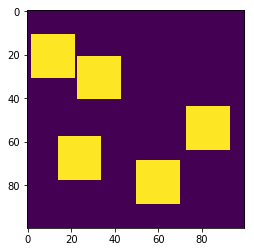

In [10]:
plt.imshow(true_maps[0])

# pad input data

In [11]:
imgs_in_1 = deepcopy(imgs_in)
for rooms in range(400):
    for j,image in enumerate(imgs_in[rooms]):
        imgs_in_1[rooms][j] = pad_images(image,xc[rooms][j]/100)


In [12]:
xc[0][10][0]/5+50,xc[0][10][1]/5+50

(20.8, 57.6)

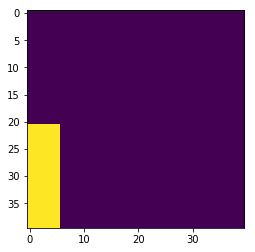

In [13]:
plt.imshow(imgs_in[0][10])

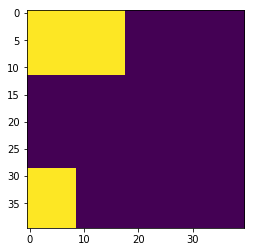

In [14]:
plt.imshow(imgs_in[0][4])

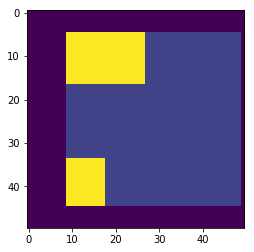

In [15]:
plt.imshow(imgs_in_1[0][4][1])

In [16]:
def tensor(obj):
    return torch.tensor(obj, device=device,dtype = torch.float)

# GVM

In [55]:
class GVM(nn.Module):

    def __init__(self, D=20, grid=(10, 10), write_size=(5,5), grid_scale=2, 
                 mins=(-2.5, -2.5), pixel_scale=20):
        
        super(GVM, self).__init__()
        self.D = D
        self.grid = grid
        self.write_size = write_size
        self.write_size_flat = write_size[0] * write_size[1] * D
        self.grid_scale = grid_scale  # number of position units per grid cells 
        self.pixel_scale = pixel_scale  # number of pixels in a position unit
        self.mins = mins
         
        # Downsampler
        self.img_write_encode = nn.Sequential(  # 50x50
            nn.Conv2d(2, 8, 3),    # 48x48
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3),   # 46x46
            nn.ReLU(True),
            nn.MaxPool2d(2),       # 23x23
            nn.Conv2d(16, 16, 3),  # 21x21
            nn.ReLU(True),
            nn.MaxPool2d(3),       # 7x7
            nn.Conv2d(16, 16, 3),  # 5x5
        )
        self.write_combine = nn.Conv2d(D + 1 + 16, D + 16, 3, padding=1)
        self.write_final = nn.Conv2d(D + 16, D, 1)
        
#         self.write1 = nn.Linear(self.write_size_flat + 64, 256)
#         self.write2 = nn.Linear(256, 256)
#         self.write3 = nn.Linear(256, self.write_size_flat)
#         self.init_mem = nn.Parameter(torch.randn(D, grid[0], grid[1]).type(torch.FloatTensor), requires_grad=True)
        #learnable initial hidden state
        
        #latest evolved hidden state
        self.embedding = None
        
        self.images = []
        #(x,y) - for all points - to be used as embedding
        self.xy_current = []
        
        #(x,y) - at probe points -to be used as classification 
        self.dropout = nn.Dropout(0.2) 
        
        self.map_decoder = nn.Sequential(
            nn.ConvTranspose2d(D + 1, 16, 5, stride=3, padding=2),  # b, 16, 28, 28
            nn.ReLU(True),
            nn.Dropout(0.1),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=2),  # b, 8, 53, 53
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=3)  # b, 1, 100, 100
        )
        
        self.sm = nn.Softmax(dim=1)
        
        self.optimizer = torch.optim.Adam(self.parameters(),weight_decay = 0.0001,  lr=0.001)

        self.to(device)
        self.prev_room_data = []
        self.counter_label_list = []
        
#     def forward_write(self, grid_mem, xy, img):

#         write_center_x = min(self.grid[0] - self.write_size[0] / 2, 
#                              max(self.write_size[0] / 2, 
#                                  round((xy[0] - self.mins[0]) / self.scale)))
#         write_center_y = min(self.grid[1] - self.write_size[1] / 2, 
#                              max(self.write_size[1] / 2, 
#                                  round((xy[0] - self.mins[1]) / self.scale)))
        
#         xy = tensor([[xy[0] - (write_center_x * self.scale + self.mins[0]), 
#                       xy[1] - (write_center_y * self.scale + self.mins[1])]])
        
#         #grid_memory = torch.zeros(self.D, self.grid[0], self.grid[1])
#         img = img.unsqueeze(0)
#         #input_encode = F.relu(torch.cat((self.xy_write_encode(xy), self.img_write_encode(img)), 1))
#         input_encode = F.relu(self.img_write_encode(img))
#         start_x = int(write_center_x - self.write_size[0] / 2)
#         start_y = int(write_center_y - self.write_size[1] / 2)
        
#         local_mem = grid_mem[:, start_x:start_x+self.write_size[0], start_y:start_y+self.write_size[0]].unsqueeze(0)

    
#         full_in = torch.cat((local_mem, input_encode), 1)
#         out = F.relu(self.write_combine(full_in))
#         out = self.write_final(out)[0]
#         grid_mem[:-1, start_x:start_x+self.write_size[0], start_y:start_y+self.write_size[0]] = out
#         grid_mem[-1, start_x:start_x+self.write_size[0], start_y:start_y+self.write_size[0]] = 1
#         return grid_mem
    
    def forward_write(self, grid_mem, xy, img):
        # Working in pixel space
        pixel_x = int((xy[0] - self.mins[0]) * self.pixel_scale)
        pixel_y = int((xy[1] - self.mins[1]) * self.pixel_scale)
        start_x = min(self.grid[0] - self.write_size[0], 
                      max(0, 
                          int((xy[0] - img.shape[-1] / 2. / self.pixel_scale - self.mins[0]) * self.grid_scale)))
        start_y = min(self.grid[1] - self.write_size[1], 
                      max(0, 
                          int((xy[1] - img.shape[-1] / 2. / self.pixel_scale - self.mins[1]) * self.grid_scale)))
        local_start_x = pixel_x - int(start_x * self.pixel_scale / self.grid_scale) - int(img.shape[1] / 2)
        local_start_y = pixel_y - int(start_y * self.pixel_scale / self.grid_scale) - int(img.shape[2] / 2)

        out = torch.zeros(1, img.shape[0] + 1, int(self.write_size[0] * self.pixel_scale / self.grid_scale), 
                                int(self.write_size[1] * self.pixel_scale / self.grid_scale)).to(device)
        
        if local_start_x < 0:
            img = img[:, -local_start_x:, :]
            local_start_x = 0
        if local_start_x+img.shape[1] > out.shape[2]:
            over = local_start_x + img.shape[1] - out.shape[2]
            img = img[:, :-over]

        if local_start_y < 0:
            img = img[:, :, -local_start_y:]
            local_start_y = 0
        if local_start_y+img.shape[2] > out.shape[3]:
            over = local_start_y + img.shape[2] - out.shape[3]
            img = img[:, :, :-over]
        with torch.no_grad():
            local_start_x = int(local_start_x)
            local_start_y = int(local_start_y)
            out[0][:-1, local_start_x:local_start_x+img.shape[1], local_start_y:local_start_y+img.shape[2]] = img
            out[0][-1][local_start_x:local_start_x+img.shape[1], local_start_y:local_start_y+img.shape[2]] = 1.    
        input_encode = F.relu(self.img_write_encode(out), inplace=True)
        local_mem = grid_mem[:, start_x:start_x+self.write_size[0], start_y:start_y+self.write_size[1]].unsqueeze(0)
        full_in = torch.cat((local_mem, input_encode), 1)
        out = F.relu(self.write_final(F.relu(self.write_combine(full_in), inplace=True)))
        #out = F.relu(self.write_final(out)[0], inplace=True)
        grid_mem[:-1, start_x:start_x+self.write_size[0], start_y:start_y+self.write_size[1]] = out
        grid_mem[-1, start_x:start_x+self.write_size[0], start_y:start_y+self.write_size[1]] = 1
        return grid_mem
    
    
    def forward_write_seq(self, xys, imgs):
        assert len(xys) == len(imgs)
        grid_mem = torch.zeros(self.D + 1, self.grid[0], self.grid[1]).to(device)
        for i in range(len(xys)):
            grid_mem = self.forward_write(grid_mem, xys[i], imgs[i])
        return grid_mem
    
    def forward_2_batch(self, mem_embed, xys):

        x1 = F.relu(self.fc_xy1(xys))
        x2 = F.relu(mem_embed.to(device))
        x2 = torch.repeat_interleave(x2,x1.shape[0]).reshape([x2.shape[1],x1.shape[0]]).t()
        x = torch.cat((x2, x1),1)
        y = F.relu(self.dropout(self.common_1(x)))
        y = F.relu(self.dropout(self.common_2(y)))
        y = F.relu(self.common_3(y))
        y1 = (self.final(y))

        return torch.cat((y1, -y1),1)
    
    def forward_map_decode(self, grid_mem):
        scores = self.map_decoder(grid_mem)
        return torch.cat((scores, -scores), 1)

    def train_K_decoder(self, imgs_in, xy_in, label_maps, K=350, min_seq_len=3, max_seq_len=10, 
                         max_epochs=10000, holdout=0, outfile=None):
        print("starting training on prev")
        start = time.time()
        rooms = range(K)
        bs = 128
        curr_hist = []
        acc_hist = []
        
        room_data = []
        for r in rooms:
            for seq_len in range(min_seq_len, min(max_seq_len + 1, imgs_in[r].shape[0])):
                room_data.append([r, seq_len])
        room_data = np.array(room_data, dtype=int)
        np.random.shuffle(room_data)
        room_data = room_data[:int(len(room_data) * (1 - holdout))]
        
        print('total training data points: ', len(room_data))
        for epoch in range(max_epochs):
            if epoch % 100 == 99 and outfile:
                torch.save(self.state_dict(), outfile + str(epoch+1) + 'ep.pth')
            self.train()           
            np.random.shuffle(room_data)
                 
            seq_images = []
            j = 0
            for r, seq_len in room_data:
                #if j==0: print(r, seq_len, pred_idx)
                element_idxs = np.random.choice(30, 
                                                seq_len, replace=False)
                seq_images = imgs_in[r][element_idxs]
                
                seq_xy = xy_in[r][element_idxs]
                
#unsqueezes state,forward expects map,grid_mem initialized without batch axis                
                pred = self.forward_map_decode(self.forward_write_seq(seq_xy, seq_images).unsqueeze(0))

                loss_function = nn.CrossEntropyLoss()#weight=tensor([.25, 1.5]))
                
                self.optimizer.zero_grad()

#                 pred = self.forward_2_batch(self.embedding, xy_list)
                temp = self.sm(pred)[:,1]>0.5 #1x108x108
                correct = (temp[0].long() == label_maps[r]) 
                acc = (float(torch.sum(correct))/(correct.shape[0] * correct.shape[1]))

                loss = loss_function(pred, label_maps[r].unsqueeze(0))  # torch.tensor(1,dtype = torch.long))

                loss.backward(retain_graph=True)

                self.optimizer.step()
                curr_hist.append(float(loss.data))
                acc_hist.append(acc)
                j += 1
                if j % 1000 == 0:
                    print(curr_hist[-1], acc)
            
            if epoch % 1 == 0:
                vl, va = validate(self, range(min_seq_len, max_seq_len+1))
                print('\r epoch %d : trainloss %.4f  trainacc %.4f  valloss %.4f  valacc %.4f  time %.2f' % 
                          (epoch + 1, np.mean(curr_hist), np.mean(acc_hist), vl, va, time.time() - start))
            
            #print(np.mean(curr_hist))
                hist.append(np.mean(curr_hist))
                val_hist.append(vl)
                curr_hist = []
                acc_hist = []

# Test

In [64]:
def validate(model, seq_range, reps=5):
        room_data = []
        rooms = range(350, 400)
        for r in rooms:
            for seq_len in seq_range:
                room_data.append([r, seq_len])
        losses = []
        accs = []  
        for _ in range(reps):
            #print(_)
            model.eval()
            np.random.shuffle(room_data)

            for r, seq_len in room_data:
                #if j==0: print(r, seq_len, pred_idx)
                element_idxs = np.random.choice(range(30), 
                                                seq_len, replace=False)
                
                seq_images = imgs_in_f[r][element_idxs]
                aug_xy = np.array(xc)/100
                seq_xy = aug_xy[r][element_idxs]
                pred = model.forward_map_decode(model.forward_write_seq(seq_xy, seq_images).unsqueeze(0))

                loss_function = nn.CrossEntropyLoss()
                
                pred_class = model.sm(pred)[:,1]>0.5
                #print(pred_class.shape)
                coarse_maps = torch.tensor(true_maps,dtype = torch.long,device=device)
                correct = (pred_class[0].long() == coarse_maps[r])
                acc = (float(torch.sum(correct))/(correct.shape[0] * correct.shape[1]))

                loss = loss_function(pred, coarse_maps[r].unsqueeze(0))  # torch.tensor(1,dtype = torch.long))
                accs.append(acc)
                losses.append(float(loss.data))
        return np.mean(losses), np.mean(accs)

In [65]:
imgs_in_f = tensor(np.stack(imgs_in)).unsqueeze(2)

In [ ]:
hist = []
val_hist = []

A=GVM()
A.to(device)
A.train_K_decoder(imgs_in_f,xc/100,torch.tensor(np.stack(true_maps),dtype = torch.long,device = device))


starting training on prev
total training data points:  2800
0.36324572563171387 0.8547
0.4495173692703247 0.7954
 epoch 1 : trainloss 0.3331  trainacc 0.8607  valloss 0.2898  valacc 0.8816  time 1063.71
0.27220606803894043 0.8806
0.26440078020095825 0.8722
 epoch 2 : trainloss 0.2736  trainacc 0.8900  valloss 0.2648  valacc 0.8933  time 2122.86
0.19234611093997955 0.9223
0.26507169008255005 0.8749
 epoch 3 : trainloss 0.2621  trainacc 0.8957  valloss 0.2540  valacc 0.8987  time 3183.43
0.20601892471313477 0.9276
0.28386372327804565 0.8869
 epoch 4 : trainloss 0.2523  trainacc 0.8998  valloss 0.2511  valacc 0.9001  time 4245.11
0.28985661268234253 0.8857
0.2801658809185028 0.9056
 epoch 5 : trainloss 0.2478  trainacc 0.9019  valloss 0.2627  valacc 0.8951  time 5308.58
0.31663191318511963 0.8737
0.21613159775733948 0.9128
 epoch 6 : trainloss 0.2444  trainacc 0.9036  valloss 0.2540  valacc 0.8995  time 6357.79
0.20246168971061707 0.9189
0.20466546714305878 0.9012
 epoch 7 : trainloss 0.2

In [ ]:
torch.save(A.state_dict(), '/home/azav/gvm')

In [ ]:
aug_xy = np.array(xc)/100
seq_xy = aug_xy[35][0:8]
seq_images = tensor(np.stack(imgs_in_1)[35][0:8])
pred = A.forward_map_decode(torch.stack(A.forward_write_seq(seq_xy, seq_images)[1]))

In [ ]:
prediction=(A.sm(pred)[:,1]>0.5).detach().cpu().numpy()

In [ ]:
plt.imshow(prediction[7])

In [54]:
40/2

20.0